In [1]:
import sys
sys.path.append('../src/')

%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10)

from scipy.integrate import simps
from benchmark.stats import calc_precision_recall, calc_ap

In [2]:
path = 'yoloface_filtered-20220427-184808'

df = pd.read_csv('./results/{}.tsv'.format(path), sep='\t', header=0, parse_dates=["Timestamp"])
df_ap = pd.read_csv('./results/{}-ap.tsv'.format(path), sep='\t', header=0)
df_ap = df_ap.sort_values(by=['Confidence'], ignore_index=True, ascending=False)
df_load = pd.read_csv('./results/{}-load.tsv'.format(path), sep='\t', header=0, parse_dates=["Timestamp"])
df_meta = pd.read_csv('./results/{}-metadata.tsv'.format(path), sep='\t', header=0)

In [3]:
df_meta

,Python,CPU,GPUs
0,3.8.8.final.0 (64 bit),AMD Ryzen 7 2700X Eight-Core Processor,"['device: 0, name: NVIDIA GeForce GTX 1080 Ti,..."


In [4]:
df_load

,Timestamp,CPU_Load,RAM_Avail
0,2022-04-27 18:48:08.315918,10.4,3465523200
1,2022-04-27 18:48:19.569914,69.6,2706817024
2,2022-04-27 18:48:33.000914,43.9,2723237888
3,2022-04-27 18:48:44.208914,72.2,2752196608
4,2022-04-27 18:48:55.593913,71.5,2725351424
...,...,...,...
129,2022-04-27 19:12:34.254412,73.2,3519184896
130,2022-04-27 19:12:45.467913,73.8,3564142592
131,2022-04-27 19:12:56.761915,72.4,3584438272
132,2022-04-27 19:13:07.994919,68.0,3620937728


In [5]:
def plot_data_over_time(time, data, label):
    plt.plot(time, data)
    plt.xlabel('Time') 
    plt.ylabel(label)
    plt.grid(True)
    plt.show()

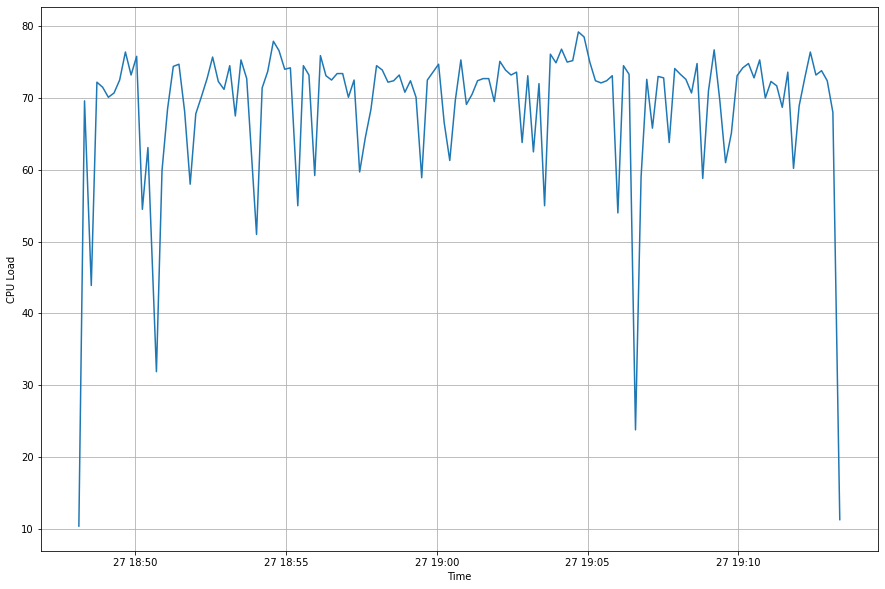

In [6]:
plot_data_over_time(df_load['Timestamp'], df_load['CPU_Load'], 'CPU Load')

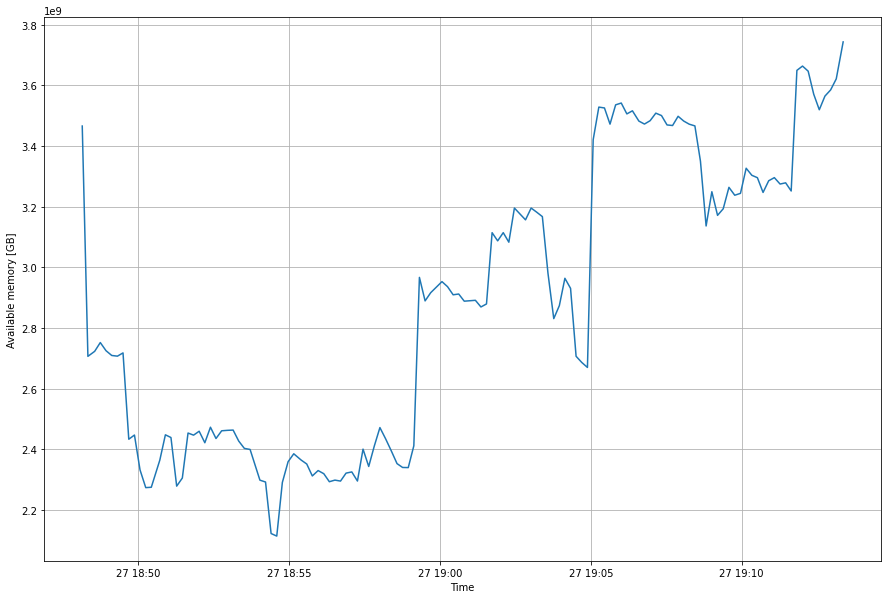

In [7]:
plot_data_over_time(df_load['Timestamp'], df_load['RAM_Avail'], 'Available memory [GB]')

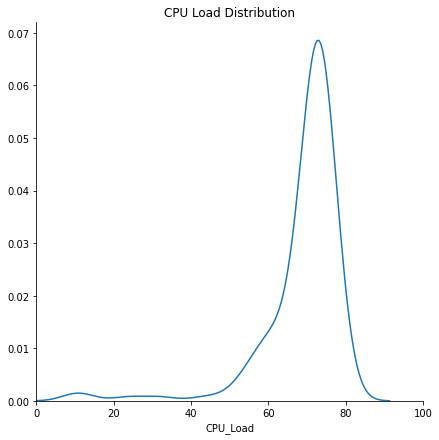

In [8]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'CPU_Load').add_legend()
plt.title('CPU Load Distribution')
plt.xlim(0, 100)
plt.show()

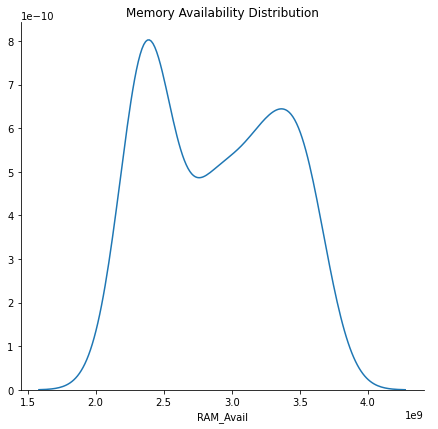

In [9]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'RAM_Avail').add_legend()
plt.title('Memory Availability Distribution')
plt.show()

In [10]:
df

,Timestamp,Speed,Precision,Recall,F1_Score,Ious,Positives,False_Positives,Negatives,Num_Of_Faces,Predicted,Ground_Truth
0,2022-04-27 18:48:09.835914,935823300,1.0,0.875,0.933333,"[0.7788707204905467, 0.856114272442225, 0.8571...",7,0,1,8,"[(788.0, 192.0, 855.0, 283.0), (178.0, 146.0, ...","[(909.0, 335.0, 974.0, 418.0), (786.0, 187.0, ..."
1,2022-04-27 18:48:10.223413,379278900,0.0,0.000,0.000000,[],0,0,1,1,[],"[(547.0, 1228.0, 688.0, 1333.0)]"
2,2022-04-27 18:48:10.696913,464731400,1.0,1.000,1.000000,[0.740495867768595],1,0,0,2,"[(461.0, 41.0, 498.0, 88.0), (553.0, 115.0, 60...","[(459.0, 45.0, 499.0, 91.0), (551.0, 107.0, 60..."
3,2022-04-27 18:48:11.189913,365519500,0.0,0.000,0.000000,[],0,0,0,62,"[(288.0, 436.0, 319.0, 468.0), (259.0, 500.0, ...","[(82.0, 278.0, 90.0, 287.0), (96.0, 272.0, 106..."
4,2022-04-27 18:48:11.592414,381281600,1.0,1.000,1.000000,"[0.8104374520337683, 0.7985791893021312, 0.816...",7,0,0,8,"[(789.0, 61.0, 833.0, 117.0), (494.0, 84.0, 53...","[(104.0, 77.0, 152.0, 135.0), (199.0, 78.0, 24..."
...,...,...,...,...,...,...,...,...,...,...,...,...
3221,2022-04-27 19:13:10.016914,382239200,1.0,1.000,1.000000,[0.873341375150784],1,0,0,1,"[(452.0, 130.0, 584.0, 327.0)]","[(452.0, 146.0, 587.0, 333.0)]"
3222,2022-04-27 19:13:10.404413,375169900,1.0,1.000,1.000000,"[0.8444463941042288, 0.767890248424175]",2,0,0,2,"[(713.0, 411.0, 796.0, 544.0), (330.0, 411.0, ...","[(324.0, 408.0, 417.0, 524.0), (712.0, 408.0, ..."
3223,2022-04-27 19:13:10.896913,392198800,0.0,0.000,0.000000,[],0,0,0,27,"[(919.0, 360.0, 954.0, 400.0), (521.0, 303.0, ...","[(70.0, 307.0, 102.0, 343.0), (121.0, 301.0, 1..."
3224,2022-04-27 19:13:11.294914,376022400,1.0,1.000,1.000000,"[0.7795603089720736, 0.84]",2,0,0,7,"[(856.0, 77.0, 897.0, 141.0), (579.0, 73.0, 61...","[(451.0, 94.0, 478.0, 121.0), (394.0, 99.0, 40..."


In [11]:
df.describe()

,Speed,Precision,Recall,F1_Score,Positives,False_Positives,Negatives,Num_Of_Faces
count,3.226000e+03,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000
mean,4.021172e+08,0.745399,0.712722,0.720887,1.931494,0.039988,0.278053,12.308741
std,3.854926e+07,0.429333,0.425777,0.422093,2.698944,0.317862,0.885645,39.822258
min,3.603867e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3.793428e+08,0.500000,0.333333,0.400000,1.000000,0.000000,0.000000,1.000000
50%,3.875798e+08,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,3.000000
75%,4.149908e+08,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,9.000000
max,9.358233e+08,1.000000,1.000000,1.000000,37.000000,8.000000,16.000000,709.000000


In [12]:
df_ap

,Confidence,TP_FP@25,TP_FP@50,TP_FP@75
0,0.999995,True,True,True
1,0.999993,True,True,True
2,0.999991,True,True,False
3,0.999991,True,True,True
4,0.999991,True,True,True
...,...,...,...,...
6355,0.503822,True,True,False
6356,0.503468,True,True,False
6357,0.502544,True,True,False
6358,0.500484,True,False,False


In [13]:
all_gts = df['Positives'].sum() + df['Negatives'].sum()

df_ap = calc_precision_recall(df_ap, all_gts)

In [14]:
df_ap

,Confidence,TP_FP@25,TP_FP@50,TP_FP@75,Precision@25,Recall@25,Precision@50,Recall@50,Precision@75,Recall@75
0,0.999995,True,True,True,1.000000,0.000140,1.000000,0.000140,1.000000,0.000140
1,0.999993,True,True,True,1.000000,0.000281,1.000000,0.000281,1.000000,0.000281
2,0.999991,True,True,False,1.000000,0.000421,1.000000,0.000421,0.666667,0.000281
3,0.999991,True,True,True,1.000000,0.000561,1.000000,0.000561,0.750000,0.000421
4,0.999991,True,True,True,1.000000,0.000701,1.000000,0.000701,0.800000,0.000561
...,...,...,...,...,...,...,...,...,...,...
6355,0.503822,True,True,False,0.980334,0.874158,0.964443,0.859989,0.671020,0.598345
6356,0.503468,True,True,False,0.980337,0.874299,0.964449,0.860129,0.670914,0.598345
6357,0.502544,True,True,False,0.980340,0.874439,0.964454,0.860269,0.670808,0.598345
6358,0.500484,True,False,False,0.980343,0.874579,0.964303,0.860269,0.670703,0.598345


In [15]:
def plot_pr(df_data, title):
    ap = calc_ap(df_data['Precision@25'], df_data['Recall@25'])
    plt.plot(df_data['Recall@25'], df_data['Precision@25'], color='darkcyan', lw=3, label="AP@0.25=%.2f" % ap)
    plt.axvline(x = df_data['Recall@25'][df_data.index[-1]], ymax=df_data['Precision@25'][df_ap.index[-1]], color = 'darkcyan')
    
    ap = calc_ap(df_data['Precision@50'], df_data['Recall@50'])
    plt.plot(df_data['Recall@50'], df_data['Precision@50'], color='darkorange', lw=3, label="AP@0.5=%.2f" % ap)
    plt.axvline(x = df_data['Recall@50'][df_data.index[-1]], ymax=df_data['Precision@50'][df_ap.index[-1]], color = 'darkorange')
    
    ap = calc_ap(df_data['Precision@75'], df_data['Recall@75'])
    plt.plot(df_data['Recall@75'], df_data['Precision@75'], color='mediumorchid', lw=3, label="AP@0.75=%.2f" % ap)
    plt.axvline(x = df_data['Recall@75'][df_data.index[-1]], ymax=df_data['Precision@75'][df_ap.index[-1]], color = 'mediumorchid')
    
    plt.xlim(0, 1.00)
    plt.ylim(0, 1.00)

    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower right", prop={'size': 16})
    plt.grid(True)

    plt.show()

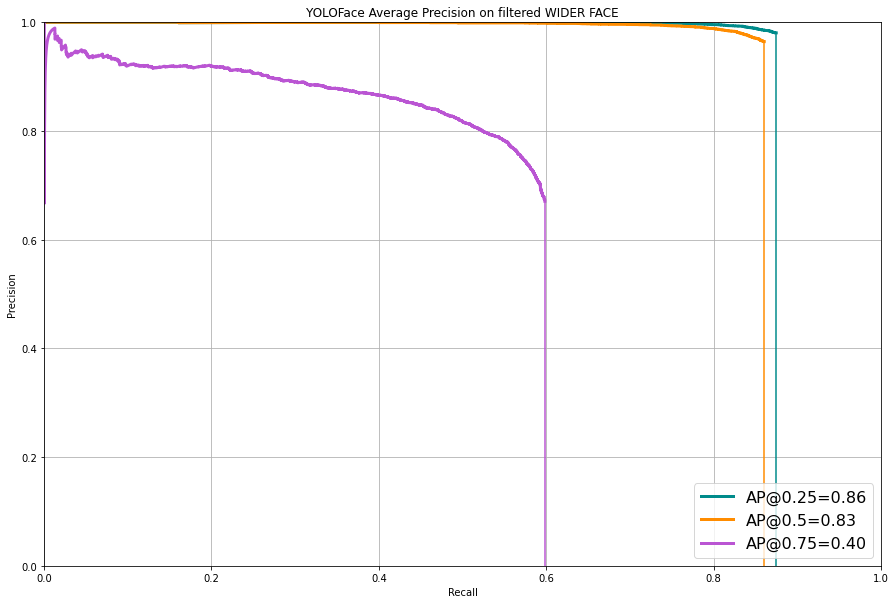

In [16]:
plot_pr(df_ap, 'YOLOFace Average Precision on filtered WIDER FACE')